In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.01 * t_u

In [3]:
def model(t_u, w1, w2, b):
    return w2 * t_u**2 + w1 * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_multi_tensor',
 'functional',
 'lr_scheduler',
 'swa_utils']

In [6]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [7]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([-2.6181e+00, -2.3049e+02, -5.9642e-02], requires_grad=True)

In [8]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # <1>
loss.backward()
optimizer.step()

params

tensor([1.1270, 1.0847, 0.1938], requires_grad=True)

In [9]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [10]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

params1 = training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params, # <1> 
    t_u = t_un,
    t_c = t_c)

params1

Epoch 500, Loss 26.266182
Epoch 1000, Loss 12.949668
Epoch 1500, Loss 6.968258
Epoch 2000, Loss 4.281574
Epoch 2500, Loss 3.074787
Epoch 3000, Loss 2.532740
Epoch 3500, Loss 2.289264
Epoch 4000, Loss 2.179901
Epoch 4500, Loss 2.130778
Epoch 5000, Loss 2.108713


tensor([ 24.3412,  27.9050, -10.3017], requires_grad=True)

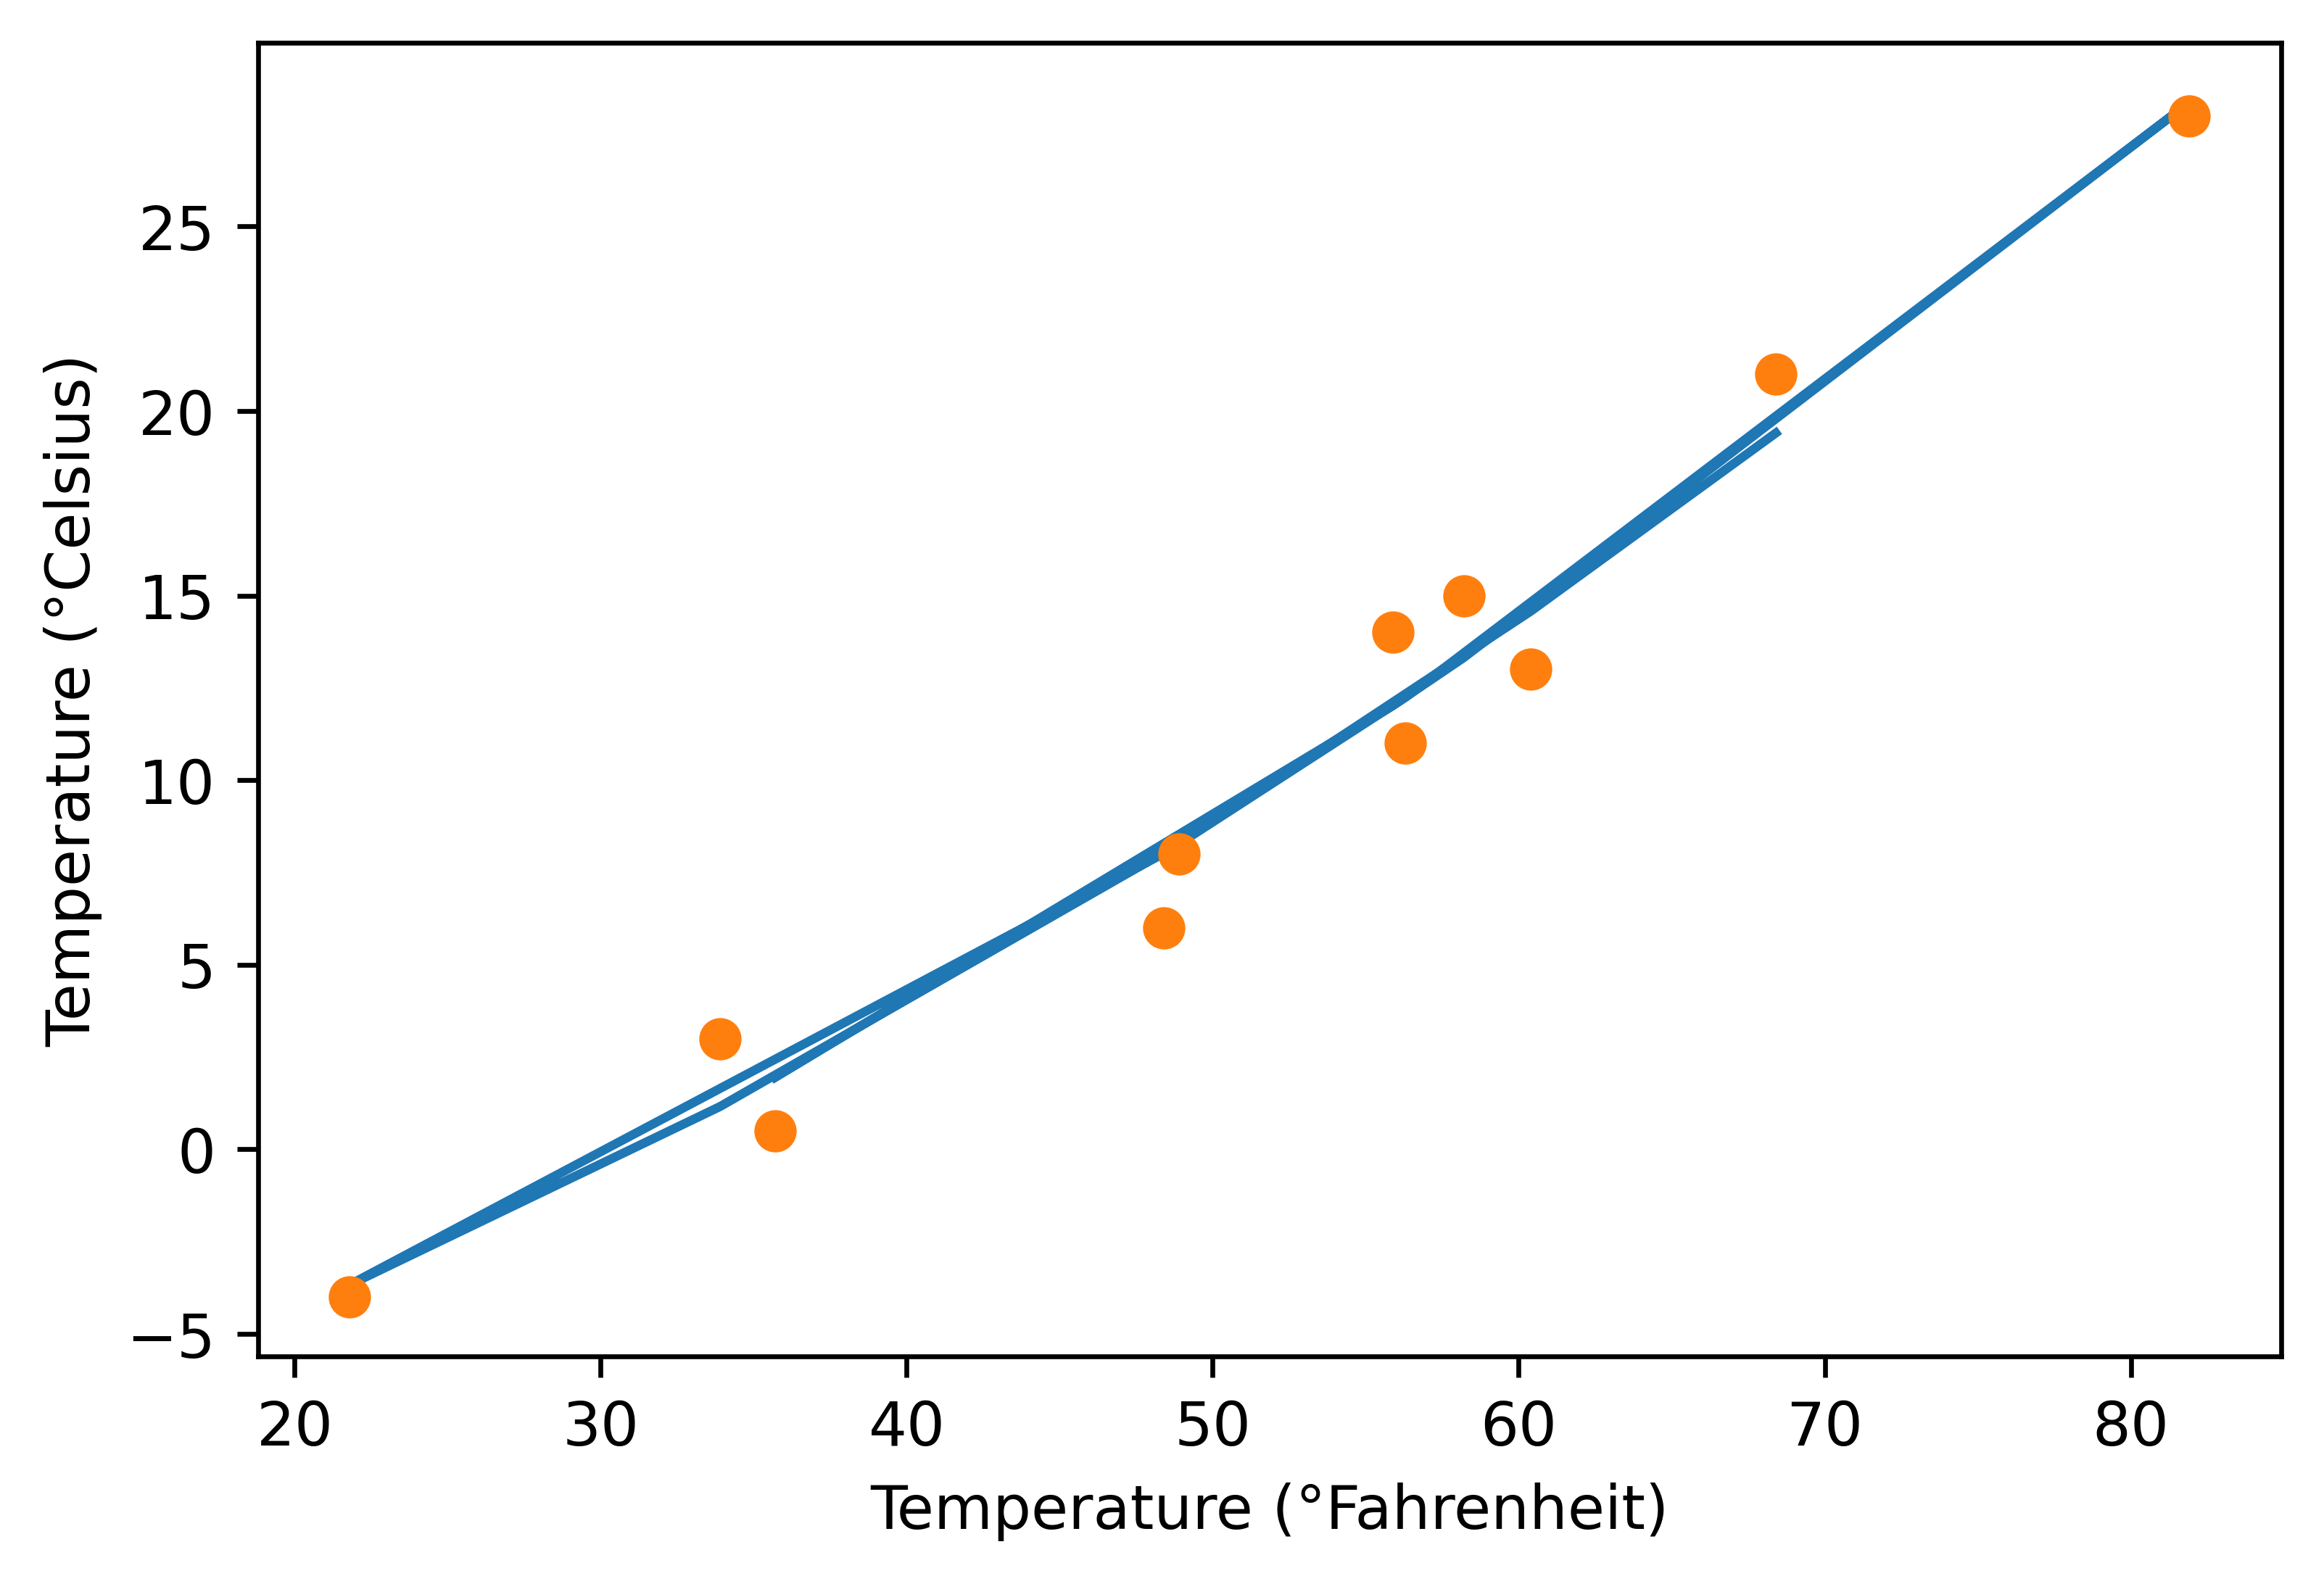

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params1)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

In [12]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate) # <1>

params2 = training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_un, # <2> 
    t_c = t_c)

params2

Epoch 500, Loss 57.949387
Epoch 1000, Loss 40.551369
Epoch 1500, Loss 33.974377
Epoch 2000, Loss 27.274971
Epoch 2500, Loss 20.752821
Epoch 3000, Loss 14.940603
Epoch 3500, Loss 10.199283
Epoch 4000, Loss 6.687762
Epoch 4500, Loss 4.367294
Epoch 5000, Loss 3.038020


tensor([19.8351, 27.2414, -7.6692], requires_grad=True)

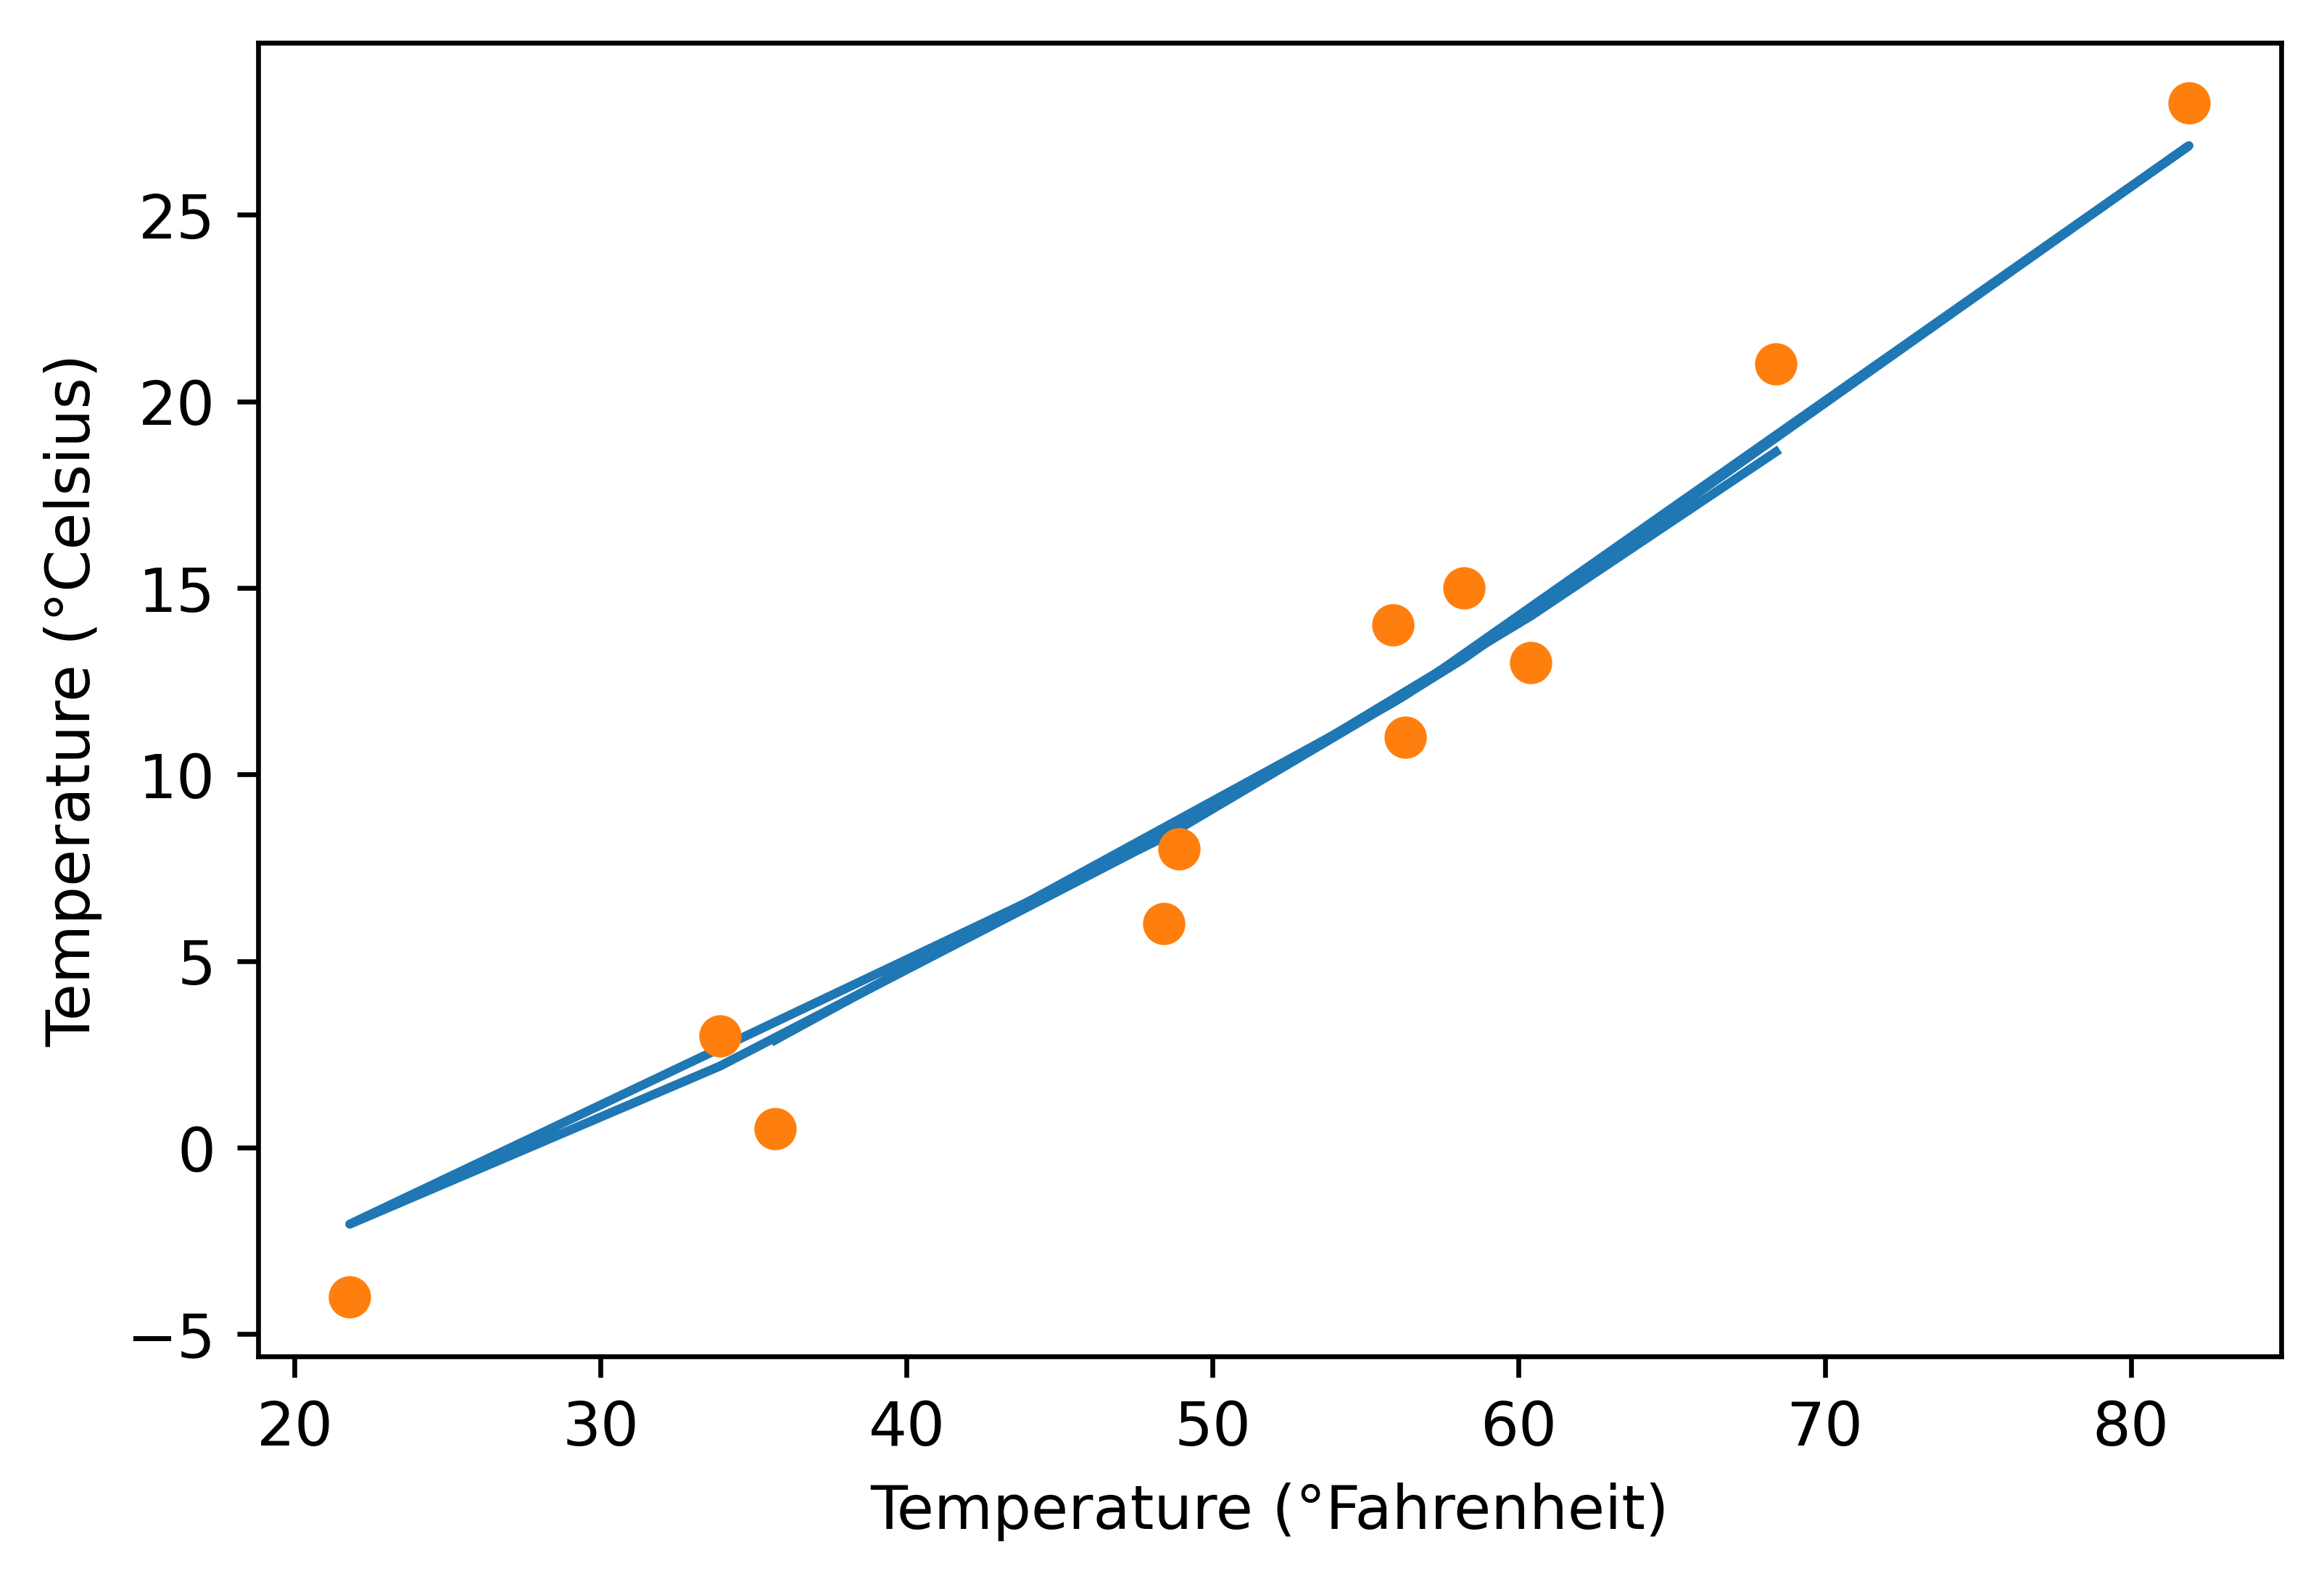

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params2)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

In [14]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices  # <1>

(tensor([ 6,  0, 10,  9,  8,  2,  1,  5,  7]), tensor([4, 3]))

In [15]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.01 * train_t_u
val_t_un = 0.01 * val_t_u

In [16]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params) # <1>
        train_loss = loss_fn(train_t_p, train_t_c)
                             
        val_t_p = model(val_t_u, *params) # <1>
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward() # <2>
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
            
    return params

In [17]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1> 
    val_t_u = val_t_un, # <1> 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 500, Training loss 26.0015, Validation loss 73.5605
Epoch 1000, Training loss 15.7857, Validation loss 38.7138
Epoch 1500, Training loss 9.9623, Validation loss 19.8776
Epoch 2000, Training loss 6.6427, Validation loss 9.9183
Epoch 2500, Training loss 4.7503, Validation loss 4.8305
Epoch 3000, Training loss 3.6714, Validation loss 2.3768
Epoch 3500, Training loss 3.0562, Validation loss 1.3166
Epoch 4000, Training loss 2.7053, Validation loss 0.9691
Epoch 4500, Training loss 2.5050, Validation loss 0.9659
Epoch 5000, Training loss 2.3906, Validation loss 1.1121


tensor([ 25.8219,  26.2495, -10.4075], requires_grad=True)

In [18]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1> 
    val_t_u = val_t_un, # <1> 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 500, Training loss 40.6183, Validation loss 152.4870
Epoch 1000, Training loss 31.9525, Validation loss 93.0121
Epoch 1500, Training loss 26.8349, Validation loss 72.0260
Epoch 2000, Training loss 21.4596, Validation loss 53.8759
Epoch 2500, Training loss 16.3175, Validation loss 37.1044
Epoch 3000, Training loss 11.8132, Validation loss 23.0398
Epoch 3500, Training loss 8.1974, Validation loss 12.4851
Epoch 4000, Training loss 5.5587, Validation loss 5.6080
Epoch 4500, Training loss 3.8389, Validation loss 2.0059
Epoch 5000, Training loss 2.8668, Validation loss 0.8511


tensor([21.1152, 28.0650, -8.5544], requires_grad=True)

In [19]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad(): # <1>
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False # <2>
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

In [20]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss